TODOS:
- ~~probably there is a bug: outout_flows are omitted if there is no output node, that means there is no constraint input==output, but the size constraint is missing then right?~~
- add coefficients
- ~~Storage~~
- FixedOutput
- ~~Proportion~~
- other solvers
    - ~~gurobi: unsupported python version~~
    - ~~highs: weird error... :-/~~
- dimension location

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/p/HiGHS/build/bin"
os.environ['GRB_LICENSE_FILE'] = '/opt/gurobi810/gurobi.lic'

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import linopy
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
#from networkx.drawing.nx_agraph import graphviz_layout


In [5]:
from network import *

# User interface starts here

In [6]:
np.random.seed(42)


def random_time_series():
    return xr.DataArray(
        np.random.rand(NUM_TIME_STEPS),
        dims="time",
        coords={"time": np.arange(NUM_TIME_STEPS)},
    )


## Example 1: No central electricity node

In [7]:
solar_pv = NodeScalableInput(name="solar_pv", input_profileile=random_time_series(), costs=10)
wind = NodeScalableInput(name="wind", input_profileile=random_time_series(), costs=5)
co2 = NodeFixInput(name="co2", costs=0, input_profileile=random_time_series())

curtail = Node(name="curtail", inputs=[solar_pv, wind], costs=0)
hydrogen = Node(name="hydrogen", inputs=[solar_pv, wind], costs=7)
curtail_h2 = Node(name="curtail_h2", inputs=[hydrogen], costs=0)

methanol_synthesis = Node(
    name="methanol_synthesis", inputs=[co2, hydrogen], costs=8, input_proportions={'co2': 0.25, 'hydrogen': 0.75}
)

network = Network([solar_pv, wind, curtail, hydrogen, curtail_h2, co2, methanol_synthesis])

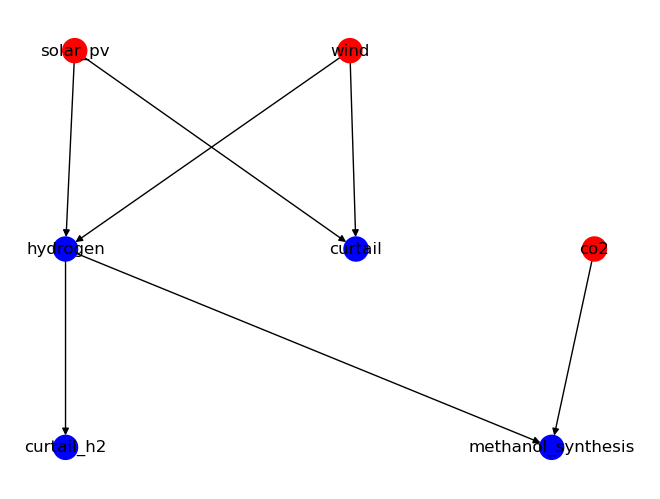

In [8]:
network.draw()

In [9]:
network.optimize('gurobi')

Writing variables.: 100%|██████████| 14/14 [00:00<00:00, 77.46it/s]


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-24
Read LP format model from file /tmp/linopy-problem-hoc4lami.lp
Reading time = 0.43 seconds
obj: 105120 rows, 87604 columns, 271560 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105120 rows, 87604 columns and 271560 nonzeros
Model fingerprint: 0x5d48381d
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-05, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 52561 columns
Presolve time: 0.22s
Presolved: 43800 rows, 35043 columns, 113880 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 7.884e+04
 Factor NZ  : 2.628e+05 (roughly 34 MB of memory)
 Factor Ops : 1.664e+06 (less than 1 second

In [10]:
network.model.solution

<xarray.Dataset>
Dimensions:                           (time: 8760)
Coordinates:
  * time                              (time) int64 0 1 2 3 ... 8757 8758 8759
Data variables: (12/14)
    size_solar_pv                     float64 53.52
    size_wind                         float64 128.4
    flow_solar_pv_curtail             (time) float64 18.36 49.09 ... 8.973 26.33
    flow_wind_curtail                 (time) float64 2.518 86.19 ... 119.7 60.88
    size_hydrogen                     float64 3.0
    flow_solar_pv_hydrogen            (time) float64 1.684 1.788 ... 2.261 0.0
    ...                                ...
    size_methanol_synthesis           float64 4.0
    flow_co2_methanol_synthesis       (time) float64 0.5612 0.5961 ... 0.1794
    flow_hydrogen_methanol_synthesis  (time) float64 1.684 1.788 ... 0.5383
    flow_curtail                      (time) float64 20.88 135.3 ... 128.7 87.21
    flow_curtail_h2                   (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    flow_methanol_synthesis           (time) float64 2.245 2.384 ... 0.7178

## Example 2: Central electricity node, no storage

In [11]:
solar_pv = NodeScalableInput(name="solar_pv", input_profile=random_time_series(), costs=10)
wind = NodeScalableInput(name="wind", input_profile=random_time_series(), costs=5)

electricity = Node(name="electricity", inputs=[solar_pv, wind], costs=0)

co2 = NodeFixInput(name="co2", costs=0, input_profile=random_time_series())

curtail = Node(name="curtail", inputs=[electricity], costs=0)
hydrogen = Node(name="hydrogen", inputs=[electricity], costs=7)
curtail_h2 = Node(name="curtail_h2", inputs=[hydrogen], costs=0)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, hydrogen],
    costs=8,
    input_proportions={"co2": 0.25, "hydrogen": 0.75},
)

network = Network(
    [
        solar_pv,
        wind,
        curtail,
        hydrogen,
        electricity,
        curtail_h2,
        co2,
        methanol_synthesis,
    ]
)



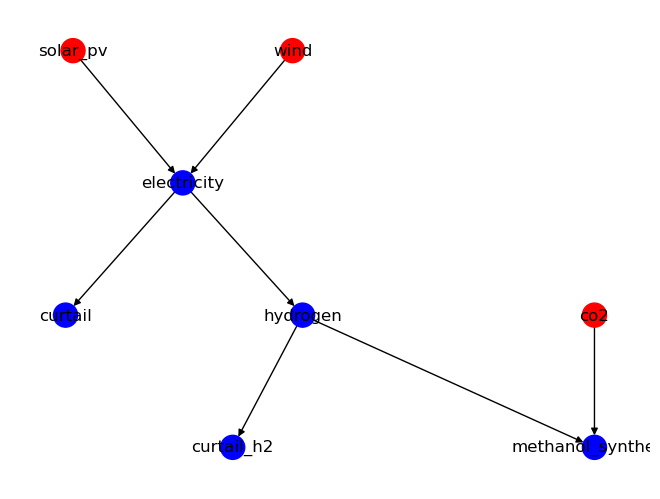

In [12]:
network.draw()

In [13]:
network.optimize('gurobi')

Writing variables.: 100%|██████████| 14/14 [00:00<00:00, 81.94it/s]

Read LP format model from file /tmp/linopy-problem-tvszyp1h.lp


Reading time = 0.39 seconds
obj: 113880 rows, 87604 columns, 262800 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 113880 rows, 87604 columns and 262800 nonzeros
Model fingerprint: 0x2f654ced
Coefficient statistics:
  Matrix range     [6e-06, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-05, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 105120 rows and 87602 columns
Presolve removed 87602 rows and 105120 columns
Presolve time: 0.43s
Presolved: 2 rows, 8760 columns, 17520 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00 (roughly 4 MB of memory)
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Prim

In [14]:
network.model.solution

<xarray.Dataset>
Dimensions:                           (time: 8760)
Coordinates:
  * time                              (time) int64 0 1 2 3 ... 8757 8758 8759
Data variables: (12/14)
    size_solar_pv                     float64 19.68
    size_wind                         float64 496.8
    flow_electricity_curtail          (time) float64 425.1 357.7 ... 162.8 241.5
    size_hydrogen                     float64 3.0
    flow_electricity_hydrogen         (time) float64 1.085 0.04176 ... 0.02385
    flow_solar_pv_electricity         (time) float64 18.41 7.718 ... 3.103 13.63
    ...                                ...
    size_methanol_synthesis           float64 4.0
    flow_co2_methanol_synthesis       (time) float64 0.3618 0.01392 ... 0.00795
    flow_hydrogen_methanol_synthesis  (time) float64 1.085 0.04176 ... 0.02385
    flow_curtail                      (time) float64 425.1 357.7 ... 162.8 241.5
    flow_curtail_h2                   (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    flow_methanol_synthesis           (time) float64 1.447 0.05568 ... 0.0318

## Example 3: Central electricity node and storage

In [15]:
NUM_TIME_STEPS = 8760

In [16]:
solar_pv = NodeScalableInput(name="solar_pv", input_profile=random_time_series(), costs=10)
wind = NodeScalableInput(name="wind", input_profile=random_time_series(), costs=5)

electricity = Node(
    name="electricity",
    inputs=[solar_pv, wind],
    costs=0,
    storage=Storage(
        costs=3, max_charging_speed=0.1, storage_loss=0.03, charging_loss=0.2
    ),
)

co2 = NodeFixInput(
    name="co2",
    costs=0,
    input_flow=random_time_series(),
    storage=Storage(
        costs=200, max_charging_speed=0.2, storage_loss=0.0, charging_loss=0.001
    ),
)

curtail = Node(name="curtail", inputs=[electricity], costs=0)
hydrogen = Node(
    name="hydrogen",
    inputs=[electricity],
    costs=7,
    storage=Storage(
        costs=200, max_charging_speed=0.2, storage_loss=0.0, charging_loss=0.001
    ),
)
curtail_h2 = Node(name="curtail_h2", inputs=[hydrogen], costs=0)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, hydrogen],
    costs=8,
    input_proportions={"co2": 0.25, "hydrogen": 0.75},
)

network = Network(
    [
        solar_pv,
        wind,
        curtail,
        hydrogen,
        electricity,
        curtail_h2,
        co2,
        methanol_synthesis,
    ]
)



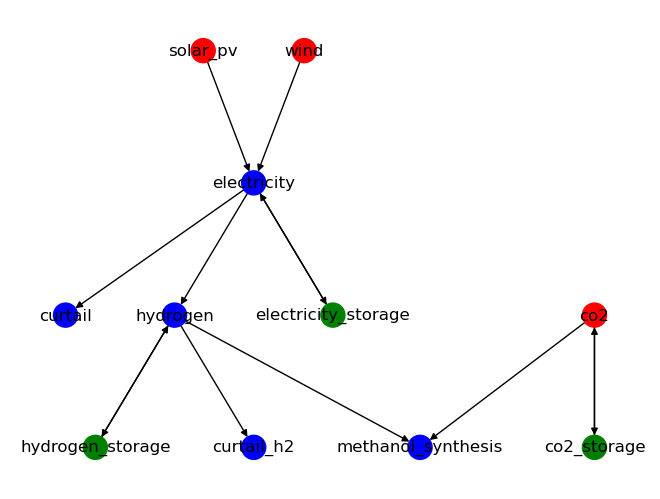

In [17]:
network.draw()

In [20]:
network.optimize('highs')

Writing variables.: 100%|██████████| 26/26 [00:00<00:00, 67.89it/s] 


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
157680 rows, 122647 cols, 446757 nonzeros
148916 rows, 113883 cols, 429227 nonzeros
Presolve : Reductions: rows 148916(-70084); columns 113883(-52564); elements 429227(-148930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8761(4388.39) 0s
      20957     1.5719252448e+02 Pr: 12588(732.432); Du: 0(5.43049e-06) 6s
      25508     1.5827048229e+02 Pr: 10009(452.832); Du: 0(6.18973e-06) 11s
      34966     1.6366838968e+02 Pr: 5529(208.628); Du: 0(5.60192e-06) 16s
      49544     1.6488498341e+02 Pr: 0(0); Du: 12(5.09837e-05) 21s
      49709     1.6488495781e+02 Pr: 0(0); Du: 0(1.96726e-07) 22s
      49709     1.6488495781e+02 Pr: 0(0); Du: 0(1.96726e-07) 22s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simp

In [19]:
network.optimize('gurobi')

Writing variables.: 100%|██████████| 26/26 [00:00<00:00, 68.29it/s]

Read LP format model from file /tmp/linopy-problem-jro0_brh.lp


Reading time = 0.76 seconds
obj: 219000 rows, 166447 columns, 578157 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 219000 rows, 166447 columns and 578157 nonzeros
Model fingerprint: 0x5df63de1
Coefficient statistics:
  Matrix range     [8e-06, 1e+00]
  Objective range  [3e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 70086 rows and 61327 columns
Presolve time: 1.07s
Presolved: 148914 rows, 105120 columns, 420459 nonzeros

Ordering time: 0.06s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 3.854e+05
 Factor NZ  : 1.967e+06 (roughly 120 MB of memory)
 Factor Ops : 2.730e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl

In [21]:
network.model.solution

<xarray.Dataset>
Dimensions:                           (time: 8760)
Coordinates:
  * time                              (time) int64 0 1 2 3 ... 8757 8758 8759
Data variables: (12/26)
    size_solar_pv                     float64 0.5512
    size_wind                         float64 3.863
    flow_electricity_curtail          (time) float64 0.8992 0.2082 ... 0.04208
    size_storage_hydrogen             float64 0.0
    storage_level_hydrogen            (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    storage_charge_hydrogen           (time) float64 -0.0 0.0 0.0 ... 0.0 0.0
    ...                                ...
    size_methanol_synthesis           float64 3.999
    flow_co2_methanol_synthesis       (time) float64 0.6826 0.2844 ... 0.7122
    flow_hydrogen_methanol_synthesis  (time) float64 2.048 0.8533 ... 2.137
    flow_curtail                      (time) float64 0.8992 0.2082 ... 0.04208
    flow_curtail_h2                   (time) float64 -0.0 -0.0 ... -0.0 -0.0
    flow_methanol_synthesis           (time) float64 2.73 1.138 ... 0.7896 2.849

## Example 4: Minimal example to test things

In [22]:
NUM_TIME_STEPS = 10

In [23]:
def const_time_series(value):
    return xr.DataArray(
        value * np.ones(NUM_TIME_STEPS),
        dims="time",
        coords={"time": np.arange(NUM_TIME_STEPS)},
    )

In [26]:
wind = NodeScalableInput(name="wind", input_profile=const_time_series(.5), costs=1)
solar_pv = NodeScalableInput(name="solar_pv", input_profile=const_time_series(.5), costs=20.)


electricity = Node(
    name="electricity",
    inputs=[solar_pv, wind],
    costs=0,
    #storage=Storage(
    #    costs=3e6, max_charging_speed=0.1, storage_loss=0.03, charging_loss=0.2
    #),
)

co2 = NodeFixInput(
    name="co2",
    input_flow=const_time_series(5),
    costs=0,
    #storage=Storage(
    #    costs=2e5, max_charging_speed=0.2, storage_loss=0.0, charging_loss=0.001
    #),
)

#curtail = Node(name="curtail", inputs=[electricity], costs=0)
#hydrogen = Node(
#    name="hydrogen",network.model.solution.size_wind
#    inputs=[electricity],
#    costs=7,
#    storage=Storage(
#        costs=2e6, max_charging_speed=0.2, storage_loss=0.0, charging_loss=0.001
#    ),
#)
#curtail_h2 = Node(name="curtail_h2", inputs=[hydrogen], costs=0)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, electricity],
    costs=8e-6,
    input_proportions={"co2": 0.25, "electricity": 0.75},
)

network = Network(
    [
        wind,
        solar_pv,
        #curtail,
        #hydrogen,
        electricity,
        #curtail_h2,
        co2,
        methanol_synthesis,
    ]
)



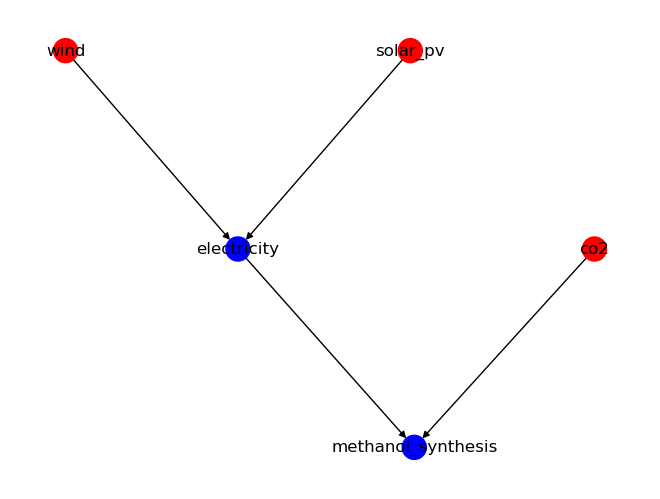

In [27]:
network.draw()

In [28]:
network.optimize('highs')

Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 87.99it/s]


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
10 rows, 2 cols, 20 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-70090); columns 0(-43803); elements 0(-140190) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  3.0000160000e+01
HiGHS run time      :          0.13


In [29]:
network.model.constraints['con0'].vars

KeyError: 'con0'

In [ ]:
network.optimize('gurobi')

Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 101.73it/s]


Read LP format model from file /tmp/linopy-problem-4ag7taji.lp
Reading time = 0.16 seconds
obj: 70090 rows, 43803 columns, 140190 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 70090 rows, 43803 columns and 140190 nonzeros
Model fingerprint: 0xab9f8f28
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-06, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 70090 rows and 43803 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0000160e+01   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.12 seconds (0.04 work units)
Optimal objective  3.000016000e+01


In [ ]:
network.model.objective

Linear Expression with 3 term(s):
----------------------------------

Dimensions:  (_term: 3)
Dimensions without coordinates: _term
Data:
    coeffs   (_term) float64 1.0 20.0 8e-06
    vars     (_term) int64 0 1 2

In [ ]:
network.model.solution

<xarray.Dataset>
Dimensions:                              (time: 8760)
Coordinates:
  * time                                 (time) int64 0 1 2 3 ... 8757 8758 8759
Data variables:
    size_wind                            float64 30.0
    size_solar_pv                        float64 0.0
    size_methanol_synthesis              float64 20.0
    flow_solar_pv_electricity            (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    flow_wind_electricity                (time) float64 15.0 15.0 ... 0.0 0.0
    flow_co2_methanol_synthesis          (time) float64 5.0 5.0 5.0 ... 0.0 0.0
    flow_electricity_methanol_synthesis  (time) float64 15.0 15.0 ... 0.0 0.0
    flow_methanol_synthesis              (time) float64 20.0 20.0 ... 0.0 0.0

# Linear increase test

In [ ]:
m = linopy.Model()
N = 100_000
var = m.add_variables(name="var", lower=xr.DataArray(np.zeros(N), dims='x', coords={'x': np.arange(N)}))


In [30]:
var - var.shift(x=1).isel(x=slice(1, None))

NameError: name 'var' is not defined

In [31]:

# m.add_constraints(var.isel(x=slice(None, -1)) - var.isel(x=slice(1, None)) == 1.)a# # 
def diff(m, i):
    if i == 0:
        # workaround, because rule has to return an AnonymousScalarConstraint
        return var[0] - var[0] == 0.
    else:
        return var[i] - var[i-1] == 1.
m.add_constraints(diff, coords=(pd.RangeIndex(N),))
m.add_objective(var.sum());
m.solve(solver_name='gurobi', keep_files=True)

NameError: name 'm' is not defined

In [32]:
m = linopy.Model()
N = 100_000
var = m.add_variables(name="var", lower=xr.DataArray(np.zeros(N), dims='x', coords={'x': np.arange(N)}))

m.add_constraints((var - var.shift(x=1)).isel(x=slice(1, None)) == 1.)
m.add_objective(var.sum());
m.solve(solver_name='gurobi', keep_files=True)
m.solution

Writing variables.: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


Read LP format model from file /tmp/linopy-problem-lsjk02gf.lp
Reading time = 0.36 seconds
obj: 99999 rows, 100000 columns, 199998 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 99999 rows, 100000 columns and 199998 nonzeros
Model fingerprint: 0x1ac5e088
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 99999 rows and 100000 columns
Presolve time: 0.13s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9999500e+09   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.26 seconds (0.08 work units)
Optimal objective  4.999950000e+09


<xarray.Dataset>
Dimensions:  (x: 100000)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 ... 99994 99995 99996 99997 99998 99999
Data variables:
    var      (x) float64 0.0 1.0 2.0 3.0 4.0 ... 1e+05 1e+05 1e+05 1e+05 1e+05

In [33]:
N = 5
m = linopy.Model()
var = m.add_variables(
    name="var", lower=xr.DataArray(np.zeros(N), dims="x", coords={"x": np.arange(N)})
)

m.add_constraints(0.5 * var == 21.0)
m.add_objective(var.sum())
m.solve(solver_name="highs", keep_files=True)
m.solution


Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-5); columns 0(-5); elements 0(-5) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  2.1000000000e+02
HiGHS run time      :          0.00


<xarray.Dataset>
Dimensions:  (x: 5)
Coordinates:
  * x        (x) int64 0 1 2 3 4
Data variables:
    var      (x) float64 42.0 42.0 42.0 42.0 42.0

# A small linopy Example to try out things

In [34]:
wind = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")
pv = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")
demand = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")

In [35]:
m = linopy.Model()

In [36]:
wind = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")
pv = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")
demand = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")

In [37]:
wind_size = m.add_variables(name="wind_size")
pv_size = m.add_variables(name="pv_size")

In [38]:
wind_size * wind


Linear Expression with 1 term(s):
----------------------------------

Dimensions:  (time: 10, _term: 1)
Dimensions without coordinates: time, _term
Data:
    coeffs   (time, _term) float64 0.9417 0.7286 0.8918 ... 0.5365 0.5679 0.975
    vars     (time, _term) int64 0 0 0 0 0 0 0 0 0 0

In [39]:
pv_size + np.array(1.0)



Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (_term: 2)
Dimensions without coordinates: _term
Data:
    coeffs   (_term) int64 1 1
    vars     (_term) int64 1 1

In [40]:
m.add_constraints(wind_size * wind + pv_size * pv >= demand)

Constraint 'con0':
------------------

Constraint labels:
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Dimensions without coordinates: time

In [41]:
m.add_objective(wind_size + 2 * pv_size)


Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (_term: 2)
Dimensions without coordinates: _term
Data:
    coeffs   (_term) int64 1 2
    vars     (_term) int64 0 1

In [42]:
m.solve(solver_name="glpk")



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-71g_ngm_.lp --output /tmp/linopy-solve-_zwy3mj8.sol
Reading problem data from '/tmp/linopy-problem-71g_ngm_.lp'...
10 rows, 2 columns, 20 non-zeros
80 lines were read
GLPK Simplex Optimizer 5.0
10 rows, 2 columns, 20 non-zeros
Preprocessing...
10 rows, 2 columns, 20 non-zeros
Scaling...
 A: min|aij| =  1.488e-02  max|aij| =  9.750e-01  ratio =  6.551e+01
GM: min|aij| =  4.465e-01  max|aij| =  2.240e+00  ratio =  5.016e+00
EQ: min|aij| =  1.994e-01  max|aij| =  1.000e+00  ratio =  5.016e+00
Constructing initial basis...
Size of triangular part is 10
      0: obj =   0.000000000e+00 inf =   7.286e+00 (10)
     10: obj =   3.833026937e+00 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (39693 bytes)
Writing basic solution to '/tmp/linopy-solve-_zwy3mj8.sol'...


('ok', 'optimal')

In [43]:
m.solve(solver_name="highs")



Running HiGHS 1.2.2 [date: 2022-09-04, git hash: 8701dbf19]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
10 rows, 2 cols, 20 nonzeros
10 rows, 2 cols, 20 nonzeros
Presolve : Reductions: rows 10(-0); columns 2(-0); elements 20(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.6000000000e+04 Ph1: 10(24263.4); Du: 2(16) 0s
          3     3.8330269371e+00 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 3
Objective value     :  3.8330269371e+00
HiGHS run time      :          0.00


('ok', 'optimal')

In [44]:
m.solve(solver_name="gurobi")



Read LP format model from file /tmp/linopy-problem-ewjjto_f.lp
Reading time = 0.00 seconds
obj: 10 rows, 2 columns, 20 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 2 columns and 20 nonzeros
Model fingerprint: 0x8df833fb
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 9e-01]
Presolve removed 6 rows and 0 columns
Presolve time: 0.01s
Presolved: 4 rows, 2 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9833435e+29   3.441576e+29   8.983344e-01      0s
       2    3.8330269e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.03 seconds (0.00 work units)
Optimal objective  3.833026937e+00


('ok', 'optimal')

In [45]:
m.solution

<xarray.Dataset>
Dimensions:    ()
Data variables:
    wind_size  float64 -0.04255
    pv_size    float64 1.938

In [46]:
m.solution

<xarray.Dataset>
Dimensions:    ()
Data variables:
    wind_size  float64 -0.04255
    pv_size    float64 1.938

# Test storage

In [47]:
import pytest
from unittest import skip
import numpy as np
import xarray as xr
from network import Storage, Network
from network import Node
from network import NodeFixInput
from network import Storage
from network import NUM_TIME_STEPS

ImportError: cannot import name 'NodeFixInput' from 'network' (/home/p/reFUEL/costs-vs-fuels/network.py)

In [ ]:

wind_flow = xr.DataArray(
    0.5 * np.ones(NUM_TIME_STEPS),
    dims="time",
    coords={"time": np.arange(NUM_TIME_STEPS)},
)
co2_flow = xr.DataArray(
    np.ones(NUM_TIME_STEPS), dims="time", coords={"time": np.arange(NUM_TIME_STEPS)}
)
co2_flow[1::2] = 0

storage = Storage(
    costs=1000, max_charging_speed=1.0, storage_loss=0.0, charging_loss=0.0
)

wind = NodeFixInput(name="wind", input_flow=wind_flow, costs=1)
hydrogen = Node(name="hydrogen", inputs=[wind], costs=3)
co2 = NodeFixInput(name="co2", input_flow=co2_flow, storage=storage)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, hydrogen],
    costs=1,
    input_proportions={"co2": 0.25, "hydrogen": 0.75},
)

network = Network([wind, hydrogen, co2, methanol_synthesis])
network.optimize("gurobi")

Writing variables.: 100%|██████████| 11/11 [00:00<00:00, 42.18it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-24


Read LP format model from file /tmp/linopy-problem-8qba_a0_.lp
Reading time = 0.60 seconds
obj: 105120 rows, 61324 columns, 245279 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 105120 rows, 61324 columns and 245279 nonzeros
Model fingerprint: 0x1b1ddba5
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 52571 rows and 43811 columns (presolve time = 5s) ...
Presolve removed 60238 rows and 51478 columns
Presolve time: 5.53s
Presolved: 44882 rows, 9846 columns, 107182 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+00
 Factor NZ  : 3.000e+00 (roughly 4 MB of memory)
 Factor Ops : 5.000e+00 (less than 1 second per iteration)
 Threads    : 1

     

In [ ]:
network.model.solution.size_wind

<xarray.DataArray 'size_wind' ()>
array(3.)

In [48]:
network.model.solution.size_wind - 3.0

<xarray.DataArray 'size_wind' ()>
array(27.)

In [49]:
np.testing.assert_almost_equal(
network.model.solution.size_wind, 3.0)

AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: <xarray.DataArray 'size_wind' ()>
array(30.)
 DESIRED: 3.0

In [ ]:

assert network.model.solution.size_hydrogen == 1.5
assert network.model.solution.size_methanol_synthesis == 2.0
assert np.all(network.model.solution.flow_wind_hydrogen == 1.5)
assert np.all(network.model.solution.flow_co2_methanol_synthesis == 0.5)
assert np.all(network.model.solution.flow_hydrogen_methanol_synthesis == 1.5)
assert np.all(network.model.solution.flow_methanol_synthesis == 2.0)

In [ ]:
np.testing.assert_array_almost_equal(network.model.solution.flow_wind_hydrogen, 1.5)

In [50]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:

%autoreload 2

In [52]:
network.model.solution

<xarray.Dataset>
Dimensions:                              (time: 8760)
Coordinates:
  * time                                 (time) int64 0 1 2 3 ... 8757 8758 8759
Data variables:
    size_wind                            float64 30.0
    size_solar_pv                        float64 0.0
    flow_solar_pv_electricity            (time) float64 -0.0 -0.0 ... 0.0 0.0
    flow_wind_electricity                (time) float64 15.0 15.0 ... 0.0 0.0
    size_methanol_synthesis              float64 20.0
    flow_co2_methanol_synthesis          (time) float64 5.0 5.0 5.0 ... 0.0 0.0
    flow_electricity_methanol_synthesis  (time) float64 15.0 15.0 ... 0.0 0.0
    flow_methanol_synthesis              (time) float64 20.0 20.0 ... 0.0 0.0

In [6]:
import network

In [7]:
network.print_constraints(network.model)


limit_outflow_by_size_hydrogen0:
+1.000000 * flow_hydrogen_methanol_synthesis23
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen1:
+1.000000 * flow_hydrogen_methanol_synthesis24
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen2:
+1.000000 * flow_hydrogen_methanol_synthesis25
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen3:
+1.000000 * flow_hydrogen_methanol_synthesis26
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen4:
+1.000000 * flow_hydrogen_methanol_synthesis27
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen5:
+1.000000 * flow_hydrogen_methanol_synthesis28
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen6:
+1.000000 * flow_hydrogen_methanol_synthesis29
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen7:
+1.000000 * flow_hydrogen_methanol_synthesis30
-1.000000 * size_hydrogen1
<=
0.000000

limit_outflow_by_size_hydrogen8:
+1.000

In [5]:
from network import timeseries_variable

In [6]:
a = timeseries_variable(network.model, 'asdf')

In [8]:
a

Variable 'asdf':
----------------

Variable labels:
array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    binary:   False

In [18]:
a

Variable 'asdf':
----------------

Variable labels:
array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    binary:   False

In [22]:
(a - a.shift(time=1)).isel(time=slice(1, None))

Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (time: 9, _term: 2)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: _term
Data:
    coeffs   (time, _term) int64 1 -1 1 -1 1 -1 1 -1 1 -1 1 -1 1 -1 1 -1 1 -1
    vars     (time, _term) int64 75 74 76 75 77 76 78 ... 79 81 80 82 81 83 82

## Issue with duplicate variables

In [5]:
N = 5
m = linopy.Model()
var = m.add_variables(
    name="var", lower=xr.DataArray(np.zeros(N), dims="x", coords={"x": np.arange(N)})
)

m.add_constraints((var - 0.5 * var) == 21.0)
m.add_objective(var.sum())
m.solve(solver_name="gurobi", keep_files=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-24
Read LP format model from file /tmp/linopy-problem-5k8do7qr.lp
Reading time = 0.01 seconds
obj: 5 rows, 5 columns, 5 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x881387a4
Coefficient statistics:
  Matrix range     [5e-01, 5e-01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+01]
Presolve removed 5 rows and 5 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.100000000e+02


('ok', 'optimal')

In [33]:
N = 5
m = linopy.Model()
var = m.add_variables(
    name="var", lower=xr.DataArray(np.zeros(N), dims="x", coords={"x": np.arange(N)})
)